In [1]:
import Revise

In [27]:
import Makie
import CairoMakie
import JLD2
import Flux
import Ab4Paper2023
using Flux: AdaBelief, flatten, Chain, Dense
using AbstractTrees: print_tree, PreOrderDFS, isroot
using Statistics: mean, cor
using Makie: @L_str
using Ab4Paper2023: posonly, log_abundances, normalize_counts

In [ ]:
# import Ab4v2
# import PhageTree
# using PhageTree: DeepEnergy, Data, log_abundances, normalize_counts

In [3]:
# load data
root_full = Ab4Paper2023.experiment_with_targets();
data_full = Ab4Paper2023.Data(root_full);
node_idx_full = Dict(n.label => t for (t, n) in enumerate(PreOrderDFS(root_full)));

In [4]:
size(data_full.sequences)

(20, 4, 76924)

In [5]:
# model trained on black and blue data (but not both)
model_black_blue, states_black_blue = JLD2.load("../data/fig2_models/indep_black+blue_reg=0.01.jld2", "model", "states");

# model trained on both and black data (but not blue)
model_black_both, states_black_both = JLD2.load("../data/fig2_models/indep_black+both_reg=0.01.jld2", "model", "states");

# model trained on both and blue data (but not black)
model_blue_both, states_blue_both = JLD2.load("../data/fig2_models/indep_blue+both_reg=0.01.jld2", "model", "states");

# model trained on both and blue data (but not black)
model_blue_only, states_blue_only = JLD2.load("../data/fig2_models/indep_blue_reg=0.01.jld2", "model", "states");

# model trained on both, predict black and blue
model_both, states_both = JLD2.load("../data/fig2_models/indep_both_reg=0.01.jld2", "model", "states");

In [6]:
model_black_blue_swap, states_black_blue_swap = JLD2.load("../data/fig2_models/indep_black+blue_reg=0.001.jld2", "model", "states");
states_black_blue_swap = (
    black = states_black_blue_swap.blue,
    blue = states_black_blue_swap.blue,
    states_black_blue_swap.common, states_black_blue_swap.amplification, states_black_blue_swap.deplification, states_black_blue_swap.wash, states_black_blue_swap.beads
)
model_black_blue_swap = Ab4Paper2023.build_model(states_black_blue_swap, root_full);

In [7]:
# swapped models for control

# control for model trained on both only ... black <-> blue, are swapped
model_both_swap, states_both_swap = JLD2.load("../data/fig2_models/indep_both_reg=0.01.jld2", "model", "states");

states_both_swap = (
    black = states_both_swap.blue,
    blue = states_both_swap.black,
    states_both_swap.common, states_both_swap.amplification, states_both_swap.deplification, states_both_swap.wash, states_both_swap.beads
)
model_both_swap = Ab4Paper2023.build_model(states_both_swap, root_full);

# control for model trained on blue only ... beads <-> blue, are swapped
model_blue_only_swap, states_blue_only_swap = JLD2.load("../data/fig2_models/indep_blue_reg=0.01.jld2", "model", "states");
states_blue_only_swap = (
    states_blue_only_swap.black,
    blue = states_blue_only_swap.beads,
    states_blue_only_swap.common, states_blue_only_swap.amplification, states_blue_only_swap.deplification, states_blue_only_swap.wash,
    beads = states_blue_only_swap.blue
)
model_blue_only_swap = Ab4Paper2023.build_model(states_blue_only_swap, root_full);

# control for model trained on black+both ... black <-> blue, are swapped
model_black_both_swap, states_black_both_swap = JLD2.load("../data/fig2_models/indep_black+both_reg=0.01.jld2", "model", "states");
states_black_both_swap = (
    black = states_black_both_swap.blue,
    blue = states_black_both_swap.black,
    states_black_both_swap.common, states_black_both_swap.amplification, states_black_both_swap.deplification, states_black_both_swap.wash, states_black_both_swap.beads
)
model_black_both_swap = Ab4Paper2023.build_model(states_black_both_swap, root_full);

# control for model trained on blue+both ... black <-> blue, are swapped
model_blue_both_swap, states_blue_both_swap = JLD2.load("../data/fig2_models/indep_blue+both_reg=0.01.jld2", "model", "states");
states_blue_both_swap = (
    black = states_blue_both_swap.blue,
    blue = states_blue_both_swap.black,
    states_blue_both_swap.common, states_blue_both_swap.amplification, states_blue_both_swap.deplification, states_blue_both_swap.wash, states_blue_both_swap.beads
)
model_blue_both_swap = Ab4Paper2023.build_model(states_blue_both_swap, root_full);

In [9]:
# control for model trained on blue+both ... black <-> blue, are swapped
model_blue_both_swap, states_blue_both_swap = JLD2.load("../data/fig2_models/indep_blue+both_reg=0.01.jld2", "model", "states");
states_blue_both_swap = (
    black = states_blue_both_swap.blue,
    blue = states_blue_both_swap.black,
    states_blue_both_swap.common, states_blue_both_swap.amplification, states_blue_both_swap.deplification, states_blue_both_swap.wash, states_blue_both_swap.beads
)
model_blue_both_swap = Ab4Paper2023.build_model(states_blue_both_swap, root_full);

In [20]:
_thresh = 50
i = node_idx_full["both 2 o+"]
p = data_full.ancestors[i]
_flag = (data_full.counts[:,i] .≥ _thresh) .& (data_full.counts[:,p] .≥ _thresh)
θ = log.(data_full.counts[:,i] ./ data_full.counts[:,p])

# true model
lN = log_abundances(model_black_blue, data_full, rare_binding=true)
lp = lN[:,i] - lN[:,p]
@info "True model cor:" cor(lp[_flag], θ[_flag])

# "swapped" model -- for control
lN = log_abundances(model_black_blue_swap, data_full, rare_binding=true)
lp = lN[:,i] - lN[:,p]
@info "Swapped model cor:" cor(lp[_flag], θ[_flag])

┌ Info: True model cor:
└   cor(lp[_flag], θ[_flag]) = 0.6319269932022776
┌ Info: Swapped model cor:
└   cor(lp[_flag], θ[_flag]) = 0.6211941063244739


In [21]:
_thresh = 50
i = node_idx_full["black 2 o+"]
p = data_full.ancestors[i]
_flag = (data_full.counts[:,i] .≥ _thresh) .& (data_full.counts[:,p] .≥ _thresh)
θ = log.(data_full.counts[:,i] ./ data_full.counts[:,p])

# true model
lN = log_abundances(model_blue_both, data_full, rare_binding=true)
lp = lN[:,i] - lN[:,p]
@info "True model cor:" cor(lp[_flag], θ[_flag])

# "swapped" model -- for control
lN = log_abundances(model_blue_both_swap, data_full, rare_binding=true)
lp = lN[:,i] - lN[:,p]
@info "Swapped model cor:" cor(lp[_flag], θ[_flag])

┌ Info: True model cor:
└   cor(lp[_flag], θ[_flag]) = 0.7040793769296128
┌ Info: Swapped model cor:
└   cor(lp[_flag], θ[_flag]) = 0.5403939409160085


In [22]:
_thresh = 50
i = node_idx_full["blue 2 o+"]
p = data_full.ancestors[i]
_flag = (data_full.counts[:,i] .≥ _thresh) .& (data_full.counts[:,p] .≥ _thresh)
θ = log.(data_full.counts[:,i] ./ data_full.counts[:,p])

# true model
lN = log_abundances(model_black_both, data_full, rare_binding=true)
lp = lN[:,i] - lN[:,p]
@info "True model cor:" cor(lp[_flag], θ[_flag])

# "swapped" model -- for control
lN = log_abundances(model_black_both_swap, data_full, rare_binding=true)
lp = lN[:,i] - lN[:,p]
@info "Swapped model cor:" cor(lp[_flag], θ[_flag])

┌ Info: True model cor:
└   cor(lp[_flag], θ[_flag]) = 0.6248314774456337
┌ Info: Swapped model cor:
└   cor(lp[_flag], θ[_flag]) = 0.6090475154598175


In [23]:
_thresh = 50
i = node_idx_full["blue 2 o+"]
p = data_full.ancestors[i]
_flag = (data_full.counts[:,i] .≥ _thresh) .& (data_full.counts[:,p] .≥ _thresh)
θ = log.(data_full.counts[:,i] ./ data_full.counts[:,p])

# true model
lN = log_abundances(model_both, data_full, rare_binding=true)
lp = lN[:,i] - lN[:,p]
@info "True model cor:" cor(lp[_flag], θ[_flag])

# "swapped" model -- for control
lN = log_abundances(model_both_swap, data_full, rare_binding=true)
lp = lN[:,i] - lN[:,p]
@info "Swapped model cor:" cor(lp[_flag], θ[_flag])

┌ Info: True model cor:
└   cor(lp[_flag], θ[_flag]) = 0.6116070975000426
┌ Info: Swapped model cor:
└   cor(lp[_flag], θ[_flag]) = 0.5591430047023146


In [24]:
_thresh = 50
i = node_idx_full["black 2 o+"]
p = data_full.ancestors[i]
_flag = (data_full.counts[:,i] .≥ _thresh) .& (data_full.counts[:,p] .≥ _thresh)
θ = log.(data_full.counts[:,i] ./ data_full.counts[:,p])

# true model
lN = log_abundances(model_both, data_full, rare_binding=true)
lp = lN[:,i] - lN[:,p]
@info "True model cor:" cor(lp[_flag], θ[_flag])

# "swapped" model -- for control
lN = log_abundances(model_both_swap, data_full, rare_binding=true)
lp = lN[:,i] - lN[:,p]
@info "Swapped model cor:" cor(lp[_flag], θ[_flag])

┌ Info: True model cor:
└   cor(lp[_flag], θ[_flag]) = 0.7074148740559582
┌ Info: Swapped model cor:
└   cor(lp[_flag], θ[_flag]) = 0.4623850751783029


In [25]:
_thresh = 50
i = node_idx_full["blue 2 o-"]
p = data_full.ancestors[i]
_flag = (data_full.counts[:,i] .≥ _thresh) .& (data_full.counts[:,p] .≥ _thresh)
θ = log.(data_full.counts[:,i] ./ data_full.counts[:,p])

# true model
lN = log_abundances(model_blue_only, data_full, rare_binding=true)
lp = lN[:,i] - lN[:,p]
@info "True model cor:" cor(lp[_flag], θ[_flag])

# "swapped" model -- for control
lN = log_abundances(model_blue_only_swap, data_full, rare_binding=true)
lp = lN[:,i] - lN[:,p]
@info "Swapped model cor:" cor(lp[_flag], θ[_flag])

┌ Info: True model cor:
└   cor(lp[_flag], θ[_flag]) = 0.5478716450018021
┌ Info: Swapped model cor:
└   cor(lp[_flag], θ[_flag]) = 0.12385719927898266


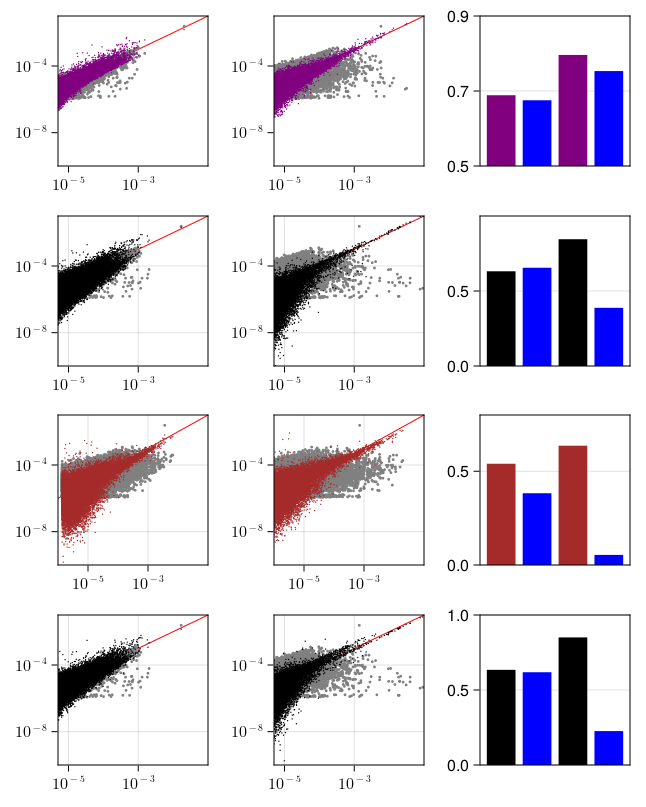

In [28]:
fig = Makie.Figure(; font="Arial")

_fig_width = 150
_thresh = 300 # count threshold for selectivity correlations

# First row: black + blue to predict both
ρs = Float64[] # selectivity correlations
for t = 1:2
    i = node_idx_full["both $t o+"]
    p = data_full.ancestors[i]
    
    lN = log_abundances(model_black_blue, data_full, rare_binding=true)

    ax = Makie.Axis(fig[1,t]; xscale=log10, yscale=log10, width=_fig_width, height=_fig_width,
        xgridvisible=false, ygridvisible=false,
        xticks=([1e-5, 1e-3], [L"10^{-5}", L"10^{-3}"]), yticks=([1e-8, 1e-4], [L"10^{-8}", L"10^{-4}"])
    )
    Makie.lines!(ax, [1e-10, 1], [1e-10, 1], color=:red, linewidth=1)
    Makie.scatter!(posonly(normalize_counts(data_full.counts)[:,i], normalize_counts(data_full.counts)[:,1])..., color=:gray, markersize=4)
    Makie.scatter!(posonly(normalize_counts(data_full.counts)[:,i], exp.(lN[:,i]))..., markersize=2, color=:purple)
    Makie.xlims!(ax, 5e-6, 1e-1)
    Makie.ylims!(ax, 1e-10, 1e-1)

    # selectivity correlations
    p = data_full.ancestors[i]
    _flag = (data_full.counts[:,i] .≥ _thresh) .& (data_full.counts[:,p] .≥ _thresh)
    θ = log.(data_full.counts[:,i] ./ data_full.counts[:,p])
    
    # "true model"
    lp = lN[:,i] - lN[:,p]
    push!(ρs, cor(lp[_flag], θ[_flag]))
    
    # "swapped" model -- for control
    lN = log_abundances(model_black_blue_swap, data_full, rare_binding=true)
    lp = lN[:,i] - lN[:,p]
    push!(ρs, cor(lp[_flag], θ[_flag])) 
end
# bar plot for selectivity correlations (as controls)
ax = Makie.Axis(fig[1,3], width=_fig_width, height=_fig_width, yticks=[0.5, 0.7, 0.9])
Makie.barplot!(ax, 0:0.2:0.6, ρs, color=[:purple, :blue, :purple, :blue])
Makie.hidexdecorations!(ax)
Makie.ylims!(ax, 0.5, 0.9)

# Second row: train on blue and both, predict black
ρs = Float64[] # selectivity correlations
for t = 1:2
    lN = log_abundances(model_blue_both, data_full, rare_binding=true)
    i = node_idx_full["black $t o+"]

    ax = Makie.Axis(fig[2,t]; xscale=log10, yscale=log10, width=_fig_width, height=_fig_width,
        xticks=([1e-5, 1e-3], [L"10^{-5}", L"10^{-3}"]), yticks=([1e-8, 1e-4], [L"10^{-8}", L"10^{-4}"])
    )
    Makie.lines!(ax, [1e-10, 1], [1e-10, 1], color=:red, linewidth=1)
    Makie.scatter!(posonly(normalize_counts(data_full.counts)[:,i], normalize_counts(data_full.counts)[:,1])..., color=:gray, markersize=4)
    Makie.scatter!(posonly(normalize_counts(data_full.counts)[:,i], exp.(lN[:,i]))..., markersize=2, color=:black)
    Makie.xlims!(ax, 5e-6, 1e-1)
    Makie.ylims!(ax, 1e-10, 1e-1)

    # selectivity correlations
    p = data_full.ancestors[i]
    _flag = (data_full.counts[:,i] .≥ _thresh) .& (data_full.counts[:,p] .≥ _thresh)
    θ = log.(data_full.counts[:,i] ./ data_full.counts[:,p])
    
    # "true model"
    lp = lN[:,i] - lN[:,p]
    push!(ρs, cor(lp[_flag], θ[_flag]))
    
    # "swapped" model -- for control
    lN = log_abundances(model_blue_both_swap, data_full, rare_binding=true)
    lp = lN[:,i] - lN[:,p]
    push!(ρs, cor(lp[_flag], θ[_flag])) 
end
# bar plot for selectivity correlations (as controls)
ax = Makie.Axis(fig[2,3], width=_fig_width, height=_fig_width, yticks=[0, 0.5])
Makie.barplot!(ax, 0:0.2:0.6, ρs, color=[:black, :blue, :black, :blue])
Makie.hidexdecorations!(ax)
Makie.ylims!(ax, 0, 1)

# Third row: train on blue (no beads), predict beads
ρs = Float64[] # selectivity correlations
for t = 1:2
    lN = log_abundances(model_blue_only, data_full, rare_binding=true)
    i = node_idx_full["blue $t o-"]

    ax = Makie.Axis(fig[3,t]; xscale=log10, yscale=log10, width=_fig_width, height=_fig_width,
        xticks=([1e-5, 1e-3], [L"10^{-5}", L"10^{-3}"]), yticks=([1e-8, 1e-4], [L"10^{-8}", L"10^{-4}"])
    )
    Makie.lines!(ax, [1e-10, 1], [1e-10, 1], color=:red, linewidth=1)
    Makie.scatter!(posonly(normalize_counts(data_full.counts)[:,i], normalize_counts(data_full.counts)[:,1])..., color=:gray, markersize=4)
    Makie.scatter!(posonly(normalize_counts(data_full.counts)[:,i], exp.(lN[:,i]))..., markersize=2, color=:brown)
    Makie.xlims!(ax, 1e-6, 1e-1)
    Makie.ylims!(ax, 1e-10, 1e-1)

    # selectivity correlations
    p = data_full.ancestors[i]
    _flag = (data_full.counts[:,i] .≥ _thresh) .& (data_full.counts[:,p] .≥ _thresh)
    θ = log.(data_full.counts[:,i] ./ data_full.counts[:,p])
    
    # "true model"
    lp = lN[:,i] - lN[:,p]
    push!(ρs, cor(lp[_flag], θ[_flag]))
    
    # "swapped" model -- for control
    lN = log_abundances(model_blue_only_swap, data_full, rare_binding=true)
    lp = lN[:,i] - lN[:,p]
    push!(ρs, cor(lp[_flag], θ[_flag])) 
end
# bar plot for selectivity correlations (as controls)
ax = Makie.Axis(fig[3,3], width=_fig_width, height=_fig_width, yticks=[0, 0.5])
Makie.barplot!(ax, 0:0.2:0.6, ρs, color=[:brown, :blue, :brown, :blue])
Makie.hidexdecorations!(ax)
Makie.ylims!(ax, 0, 0.8)

# Fourth row: train on both, predict black & blue
ρs = Float64[] # selectivity correlations
for t in 1:2
    lN = log_abundances(model_both, data_full, rare_binding=true)
    i = node_idx_full["black $t o+"]

    ax = Makie.Axis(fig[4,t]; xscale=log10, yscale=log10, width=_fig_width, height=_fig_width,
        xticks=([1e-5, 1e-3], [L"10^{-5}", L"10^{-3}"]), yticks=([1e-8, 1e-4], [L"10^{-8}", L"10^{-4}"])
    )
    Makie.lines!(ax, [1e-10, 1], [1e-10, 1], color=:red, linewidth=1)
    Makie.scatter!(posonly(normalize_counts(data_full.counts)[:,i], normalize_counts(data_full.counts)[:,1])..., color=:gray, markersize=4)
    Makie.scatter!(posonly(normalize_counts(data_full.counts)[:,i], exp.(lN[:,i]))..., markersize=2, color=:black)
    Makie.xlims!(ax, 5e-6, 1e-1)
    Makie.ylims!(ax, 1e-10, 1e-1)

    # selectivity correlations
    p = data_full.ancestors[i]
    _flag = (data_full.counts[:,i] .≥ _thresh) .& (data_full.counts[:,p] .≥ _thresh)
    θ = log.(data_full.counts[:,i] ./ data_full.counts[:,p])
    
    # "true model"
    lp = lN[:,i] - lN[:,p]
    push!(ρs, cor(lp[_flag], θ[_flag]))
    
    # "swapped" model -- for control
    lN = log_abundances(model_both_swap, data_full, rare_binding=true)
    lp = lN[:,i] - lN[:,p]
    push!(ρs, cor(lp[_flag], θ[_flag]))
end
# bar plot for selectivity correlations (as controls)
ax = Makie.Axis(fig[4,3], width=_fig_width, height=_fig_width, yticks=[0, 0.5, 1])
Makie.barplot!(ax, [0, 0.2, 0.4, 0.6], ρs, color=[:black, :blue, :black, :blue])
Makie.hidexdecorations!(ax)
Makie.ylims!(ax, 0, 1)

Makie.resize_to_layout!(fig)
#Makie.save("fig/fig2_indep.pdf", fig)
fig